In [ ]:
!pip install monai

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from glob import glob
import shutil
import os
import nibabel as nib
import numpy as np
from tqdm import tqdm

from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
    ScaleIntensity,
    RandRotate,
    RandFlip,
    RandZoom,
    RandGaussianNoise,
    Resize,
)
from monai.utils import first
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism
from matplotlib import pyplot as plt
from monai.losses import DiceLoss, DiceCELoss
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.data import CacheDataset, DataLoader, Dataset
from monai.inferers import sliding_window_inference

import torch

In [ ]:
'''
preprocessing functions below doing preprocessing of data which is nifti format

-> we are using Monai transforms to transforme our data.
-> We are using basic transforms after using various diffrent tranforms the below sequence is giving the good result.
'''



def pre_process_data(in_dir, pixdim=(1.5, 1.5, 1.0), a_min=-200, a_max=200, spatial_size=[128,128,64]):


    set_determinism(seed=0)

    train_vol_path = sorted(glob(os.path.join(in_dir, "TrainVolumes", "*.nii.gz")))
    train_seg_path = sorted(glob(os.path.join(in_dir, "TrainSegmentation", "*.nii.gz")))

    test_vol_path = sorted(glob(os.path.join(in_dir, "TestVolumes", "*.nii.gz")))
    test_seg_path = sorted(glob(os.path.join(in_dir, "TestSegmentation", "*.nii.gz")))

    train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(train_vol_path, train_seg_path)]
    test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(test_vol_path, test_seg_path)]
    
    # print(test_files);

    train_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            AddChanneld(keys=["vol", "seg"]),
            # ScaleIntensity(),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            # RandFlip(spatial_axis=0, prob=0.5),
            # RandRotate(prob=0.3),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, b_min=0.0, b_max=1.0, clip=True), 
            CropForegroundd(keys=["vol", "seg"], source_key="vol"),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),   
            ToTensord(keys=["vol", "seg"]),
            # RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
            # RandGaussianNoise(prob = 0.5),
        ]
    )

    test_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            AddChanneld(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max,b_min=0.0, b_max=1.0, clip=True), 
            CropForegroundd(keys=['vol', 'seg'], source_key='vol'),
            Resized(keys=["vol", "seg"], spatial_size=spatial_size),   
            ToTensord(keys=["vol", "seg"]),

            
        ]
    )

    
    train_dataset = Dataset(data=train_files, transform=train_transforms)
    tr_loader = DataLoader(train_dataset, batch_size=1)             ##loading data into a vetor.

    test_dataset = Dataset(data=test_files, transform=test_transforms)
    ts_loader = DataLoader(test_dataset, batch_size=1)

    return [tr_loader, ts_loader]

In [ ]:
def show_sample(data, SLICE_NUMBER=1, train=True, test=False): ## function is to show sample data to visualise.
    

    check_patient_train = data[0]; ##train data
    check_patient_test = data[1] ## test data

    view_train_patient = first(check_patient_train)
    view_test_patient = first(check_patient_test)
    # print(check_patient_train);
    # print(view_train_patient);

    if train:
        plt.figure("Visualization Train", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_train_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_train_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()
    
    if test:
        plt.figure("Visualization Test", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_test_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_test_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()


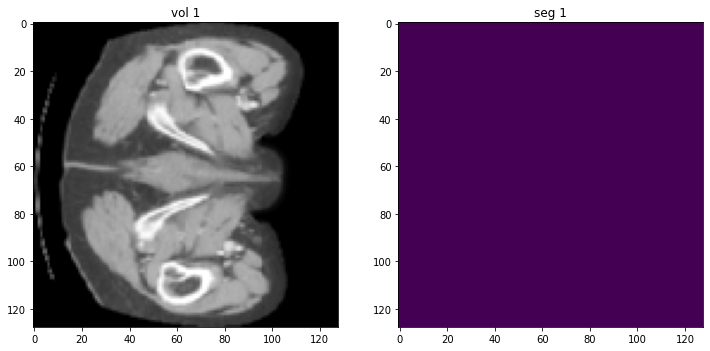

In [ ]:
in_dir = '/content/drive/My Drive/Dataset/Data_Train_Test/'
model_dir = '/content/drive/My Drive/Dataset/results/results'

data_in  = pre_process_data(in_dir)
# data_in
show_sample(data_in)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
'''
    Dice loss: The Dice coefficient is widely used metric in computer vision community to calculate the similarity between two images.
                and then form a metric of training and testing.

'''
def cal_dice_matric(predicted, target):
  
    dice_value = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
    value = 1 - dice_value(predicted, target).item()
    return value

In [ ]:
# saving checkpoint

def save_ckp(state, is_best, checkpoint_dir, best_model_dir):
    f_path = os.path.join(checkpoint_dir, 'checkpoint.pth')
    torch.save(state, f_path)
    if is_best:
        best_fpath = os.path.join(best_model_dir , 'best_metric_model.pth')
        shutil.copyfile(f_path, best_fpath)

In [ ]:
save_loss_train = []
save_loss_test = []
save_metric_train = []
save_metric_test = []


def train(model, data_in, loss, optim,start_epoch, max_epochs, model_dir, test_interval=1 , device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")):
    best_metric = -1
    best_metric_epoch = -1
    tr_loader, ts_loader = data_in

    for epoch in tqdm(range(start_epoch, max_epochs)):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}")
        model.train()
        train_epoch_loss = 0
        train_step = 0
        epoch_metric_train = 0
        for batch_data in tr_loader:
            
            train_step += 1

            volume = batch_data["vol"]
            label = batch_data["seg"]
            label = label != 0
            volume, label = (volume.to(device), label.to(device))

            optim.zero_grad()
            outputs = model(volume)
            
            train_loss = loss(outputs, label)
            
            train_loss.backward()
            optim.step()

            train_epoch_loss += train_loss.item()
            print(
                f"{train_step}/{len(tr_loader) // tr_loader.batch_size},"
                f"Train_loss: {train_loss.item():.4f}")

            train_metric = cal_dice_matric(outputs, label)
            epoch_metric_train += train_metric
            print(f'Train_dice: {train_metric:.4f}')

        print('-'*20)
        
        train_epoch_loss /= train_step

        print(f'Epoch_loss: {train_epoch_loss:.4f}')
        save_loss_train.append(train_epoch_loss)
        np.save(os.path.join(model_dir, 'loss_train.npy'), save_loss_train)
        
        epoch_metric_train /= train_step
        print(f'Epoch_metric: {epoch_metric_train:.4f}')

        save_metric_train.append(epoch_metric_train)
        np.save(os.path.join(model_dir, 'metric_train.npy'), save_metric_train)

        if (epoch + 1) % test_interval == 0:

            model.eval()
            with torch.no_grad():
                test_epoch_loss = 0
                test_metric = 0
                epoch_metric_test = 0
                test_step = 0

                for test_data in ts_loader:

                    test_step += 1

                    test_volume = test_data["vol"]
                    test_label = test_data["seg"]
                    test_label = test_label != 0
                    test_volume, test_label = (test_volume.to(device), test_label.to(device),)
                    
                    test_outputs = model(test_volume)
                    
                    test_loss = loss(outputs, test_label)
                    test_epoch_loss += test_loss.item()
                    test_metric = cal_dice_matric(test_outputs, test_label)
                    epoch_metric_test += test_metric
                    
                
                test_epoch_loss /= test_step
                print(f'test_loss_epoch: {test_epoch_loss:.4f}')
                save_loss_test.append(test_epoch_loss)
                np.save(os.path.join(model_dir, 'loss_test.npy'), save_loss_test)

                epoch_metric_test /= test_step
                print(f'test_dice_epoch: {epoch_metric_test:.4f}')
                save_metric_test.append(epoch_metric_test)
                np.save(os.path.join(model_dir, 'metric_test.npy'), save_metric_test)

                # adding checkpoint system in training
                is_best =0
                if epoch_metric_test > best_metric:
                    best_metric = epoch_metric_test
                    best_metric_epoch = epoch + 1
                    is_best =1
              
                checkpoint = {
                    'epoch': epoch + 1,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict()
                }
                save_ckp(checkpoint, is_best, model_dir, model_dir)
                # Until here
                
                print(
                    f"current epoch: {epoch + 1} current mean dice: {test_metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )


    print(
        f"train completed, best_metric: {best_metric:.4f} "
        f"at epoch: {best_metric_epoch}")

In [ ]:
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256), 
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)


In [ ]:
loss_fn = DiceLoss(to_onehot_y=True, sigmoid=True, squared_pred=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-5, weight_decay=1e-5, amsgrad=True)

In [ ]:
def load_ckp(checkpoint_fpath, model, optimizer):
    checkpoint = torch.load(checkpoint_fpath,map_location=torch.device("cpu"))
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    return model, optimizer, checkpoint['epoch']

In [ ]:
start_epoch = 0
ckp_path = "/content/drive/MyDrive/Dataset/results/results/checkpoint.pth"
# model, optimizer, start_epoch = load_ckp(ckp_path, model, optimizer)


In [ ]:
if __name__ == '__main__':

    train(model, data_in, loss_function, optimizer,start_epoch,start_epoch+ 44, model_dir,test_interval=2)

  0%|          | 0/44 [00:00<?, ?it/s]

----------
epoch 77/120
1/42,Train_loss: 0.3816
Train_dice: 0.6184
2/42,Train_loss: 0.3918
Train_dice: 0.6082
3/42,Train_loss: 0.3959
Train_dice: 0.6041
4/42,Train_loss: 0.4273
Train_dice: 0.5727
5/42,Train_loss: 0.3728
Train_dice: 0.6272
6/42,Train_loss: 0.5390
Train_dice: 0.4610
7/42,Train_loss: 0.4180
Train_dice: 0.5820
8/42,Train_loss: 0.4516
Train_dice: 0.5484
9/42,Train_loss: 0.2169
Train_dice: 0.7831
10/42,Train_loss: 0.5373
Train_dice: 0.4627
11/42,Train_loss: 0.2732
Train_dice: 0.7268
12/42,Train_loss: 0.2381
Train_dice: 0.7619
13/42,Train_loss: 0.3436
Train_dice: 0.6564
14/42,Train_loss: 0.4091
Train_dice: 0.5909
15/42,Train_loss: 0.1870
Train_dice: 0.8130
16/42,Train_loss: 0.4434
Train_dice: 0.5566
17/42,Train_loss: 0.2018
Train_dice: 0.7982
18/42,Train_loss: 0.5176
Train_dice: 0.4824
19/42,Train_loss: 0.1996
Train_dice: 0.8004
20/42,Train_loss: 0.2671
Train_dice: 0.7329
21/42,Train_loss: 0.3182
Train_dice: 0.6818
22/42,Train_loss: 0.3463
Train_dice: 0.6537
23/42,Train_loss:

  2%|▏         | 1/44 [03:50<2:45:23, 230.77s/it]

----------
epoch 78/120
1/42,Train_loss: 0.3805
Train_dice: 0.6195
2/42,Train_loss: 0.3909
Train_dice: 0.6091
3/42,Train_loss: 0.3951
Train_dice: 0.6049
4/42,Train_loss: 0.4265
Train_dice: 0.5735
5/42,Train_loss: 0.3723
Train_dice: 0.6277
6/42,Train_loss: 0.5387
Train_dice: 0.4613
7/42,Train_loss: 0.4173
Train_dice: 0.5827
8/42,Train_loss: 0.4508
Train_dice: 0.5492
9/42,Train_loss: 0.2159
Train_dice: 0.7841
10/42,Train_loss: 0.5370
Train_dice: 0.4630
11/42,Train_loss: 0.2728
Train_dice: 0.7272
12/42,Train_loss: 0.2374
Train_dice: 0.7626
13/42,Train_loss: 0.3438
Train_dice: 0.6562
14/42,Train_loss: 0.4086
Train_dice: 0.5914
15/42,Train_loss: 0.1864
Train_dice: 0.8136
16/42,Train_loss: 0.4427
Train_dice: 0.5573
17/42,Train_loss: 0.2011
Train_dice: 0.7989
18/42,Train_loss: 0.5172
Train_dice: 0.4828
19/42,Train_loss: 0.1987
Train_dice: 0.8013
20/42,Train_loss: 0.2663
Train_dice: 0.7337
21/42,Train_loss: 0.3169
Train_dice: 0.6831
22/42,Train_loss: 0.3446
Train_dice: 0.6554
23/42,Train_loss:

  5%|▍         | 2/44 [06:20<2:08:05, 182.98s/it]

current epoch: 78 current mean dice: 0.6558
best mean dice: 0.6765 at epoch: 78
----------
epoch 79/120
1/42,Train_loss: 0.3798
Train_dice: 0.6202
2/42,Train_loss: 0.3902
Train_dice: 0.6098
3/42,Train_loss: 0.3939
Train_dice: 0.6061
4/42,Train_loss: 0.4256
Train_dice: 0.5744
5/42,Train_loss: 0.3706
Train_dice: 0.6294
6/42,Train_loss: 0.5384
Train_dice: 0.4616
7/42,Train_loss: 0.4163
Train_dice: 0.5837
8/42,Train_loss: 0.4499
Train_dice: 0.5501
9/42,Train_loss: 0.2145
Train_dice: 0.7855
10/42,Train_loss: 0.5367
Train_dice: 0.4633
11/42,Train_loss: 0.2705
Train_dice: 0.7295
12/42,Train_loss: 0.2353
Train_dice: 0.7647
13/42,Train_loss: 0.3418
Train_dice: 0.6582
14/42,Train_loss: 0.4076
Train_dice: 0.5924
15/42,Train_loss: 0.1840
Train_dice: 0.8160
16/42,Train_loss: 0.4419
Train_dice: 0.5581
17/42,Train_loss: 0.1992
Train_dice: 0.8008
18/42,Train_loss: 0.5168
Train_dice: 0.4832
19/42,Train_loss: 0.1977
Train_dice: 0.8023
20/42,Train_loss: 0.2652
Train_dice: 0.7348
21/42,Train_loss: 0.3165


  7%|▋         | 3/44 [08:21<1:45:52, 154.95s/it]

42/42,Train_loss: 0.3262
Train_dice: 0.6738
--------------------
Epoch_loss: 0.3663
Epoch_metric: 0.6337
----------
epoch 80/120
1/42,Train_loss: 0.3787
Train_dice: 0.6213
2/42,Train_loss: 0.3891
Train_dice: 0.6109
3/42,Train_loss: 0.3931
Train_dice: 0.6069
4/42,Train_loss: 0.4248
Train_dice: 0.5752
5/42,Train_loss: 0.3698
Train_dice: 0.6302
6/42,Train_loss: 0.5381
Train_dice: 0.4619
7/42,Train_loss: 0.4155
Train_dice: 0.5845
8/42,Train_loss: 0.4492
Train_dice: 0.5508
9/42,Train_loss: 0.2133
Train_dice: 0.7867
10/42,Train_loss: 0.5363
Train_dice: 0.4637
11/42,Train_loss: 0.2692
Train_dice: 0.7308
12/42,Train_loss: 0.2343
Train_dice: 0.7657
13/42,Train_loss: 0.3403
Train_dice: 0.6597
14/42,Train_loss: 0.4064
Train_dice: 0.5936
15/42,Train_loss: 0.1832
Train_dice: 0.8168
16/42,Train_loss: 0.4410
Train_dice: 0.5590
17/42,Train_loss: 0.1980
Train_dice: 0.8020
18/42,Train_loss: 0.5164
Train_dice: 0.4836
19/42,Train_loss: 0.1960
Train_dice: 0.8040
20/42,Train_loss: 0.2634
Train_dice: 0.7366


  9%|▉         | 4/44 [10:31<1:36:42, 145.07s/it]

current epoch: 80 current mean dice: 0.6506
best mean dice: 0.6765 at epoch: 78
----------
epoch 81/120
1/42,Train_loss: 0.3776
Train_dice: 0.6224
2/42,Train_loss: 0.3881
Train_dice: 0.6119
3/42,Train_loss: 0.3922
Train_dice: 0.6078
4/42,Train_loss: 0.4240
Train_dice: 0.5760
5/42,Train_loss: 0.3688
Train_dice: 0.6312
6/42,Train_loss: 0.5379
Train_dice: 0.4621
7/42,Train_loss: 0.4146
Train_dice: 0.5854
8/42,Train_loss: 0.4485
Train_dice: 0.5515
9/42,Train_loss: 0.2118
Train_dice: 0.7882
10/42,Train_loss: 0.5361
Train_dice: 0.4639
11/42,Train_loss: 0.2686
Train_dice: 0.7314
12/42,Train_loss: 0.2330
Train_dice: 0.7670
13/42,Train_loss: 0.3398
Train_dice: 0.6602
14/42,Train_loss: 0.4058
Train_dice: 0.5942
15/42,Train_loss: 0.1821
Train_dice: 0.8179
16/42,Train_loss: 0.4404
Train_dice: 0.5596
17/42,Train_loss: 0.1970
Train_dice: 0.8030
18/42,Train_loss: 0.5159
Train_dice: 0.4841
19/42,Train_loss: 0.1947
Train_dice: 0.8053
20/42,Train_loss: 0.2624
Train_dice: 0.7376
21/42,Train_loss: 0.3132


 11%|█▏        | 5/44 [12:31<1:28:24, 136.01s/it]

42/42,Train_loss: 0.3241
Train_dice: 0.6759
--------------------
Epoch_loss: 0.3645
Epoch_metric: 0.6355
----------
epoch 82/120
1/42,Train_loss: 0.3766
Train_dice: 0.6234
2/42,Train_loss: 0.3872
Train_dice: 0.6128
3/42,Train_loss: 0.3912
Train_dice: 0.6088
4/42,Train_loss: 0.4231
Train_dice: 0.5769
5/42,Train_loss: 0.3675
Train_dice: 0.6325
6/42,Train_loss: 0.5376
Train_dice: 0.4624
7/42,Train_loss: 0.4137
Train_dice: 0.5863
8/42,Train_loss: 0.4480
Train_dice: 0.5520
9/42,Train_loss: 0.2106
Train_dice: 0.7894
10/42,Train_loss: 0.5358
Train_dice: 0.4642
11/42,Train_loss: 0.2663
Train_dice: 0.7337
12/42,Train_loss: 0.2314
Train_dice: 0.7686
13/42,Train_loss: 0.3381
Train_dice: 0.6619
14/42,Train_loss: 0.4048
Train_dice: 0.5952
15/42,Train_loss: 0.1804
Train_dice: 0.8196
16/42,Train_loss: 0.4397
Train_dice: 0.5603
17/42,Train_loss: 0.1957
Train_dice: 0.8043
18/42,Train_loss: 0.5155
Train_dice: 0.4845
19/42,Train_loss: 0.1939
Train_dice: 0.8061
20/42,Train_loss: 0.2614
Train_dice: 0.7386


 14%|█▎        | 6/44 [14:45<1:25:34, 135.13s/it]

current epoch: 82 current mean dice: 0.6586
best mean dice: 0.6795 at epoch: 82
----------
epoch 83/120
1/42,Train_loss: 0.3757
Train_dice: 0.6243
2/42,Train_loss: 0.3862
Train_dice: 0.6138
3/42,Train_loss: 0.3904
Train_dice: 0.6096
4/42,Train_loss: 0.4223
Train_dice: 0.5777
5/42,Train_loss: 0.3671
Train_dice: 0.6329
6/42,Train_loss: 0.5372
Train_dice: 0.4628
7/42,Train_loss: 0.4129
Train_dice: 0.5871
8/42,Train_loss: 0.4469
Train_dice: 0.5531
9/42,Train_loss: 0.2097
Train_dice: 0.7903
10/42,Train_loss: 0.5355
Train_dice: 0.4645
11/42,Train_loss: 0.2659
Train_dice: 0.7341
12/42,Train_loss: 0.2312
Train_dice: 0.7688
13/42,Train_loss: 0.3373
Train_dice: 0.6627
14/42,Train_loss: 0.4037
Train_dice: 0.5963
15/42,Train_loss: 0.1798
Train_dice: 0.8202
16/42,Train_loss: 0.4388
Train_dice: 0.5612
17/42,Train_loss: 0.1944
Train_dice: 0.8056
18/42,Train_loss: 0.5151
Train_dice: 0.4849
19/42,Train_loss: 0.1921
Train_dice: 0.8079
20/42,Train_loss: 0.2597
Train_dice: 0.7403
21/42,Train_loss: 0.3109


 16%|█▌        | 7/44 [16:45<1:20:26, 130.44s/it]

42/42,Train_loss: 0.3215
Train_dice: 0.6785
--------------------
Epoch_loss: 0.3627
Epoch_metric: 0.6373
----------
epoch 84/120
1/42,Train_loss: 0.3745
Train_dice: 0.6255
2/42,Train_loss: 0.3851
Train_dice: 0.6149
3/42,Train_loss: 0.3892
Train_dice: 0.6108
4/42,Train_loss: 0.4214
Train_dice: 0.5786
5/42,Train_loss: 0.3655
Train_dice: 0.6345
6/42,Train_loss: 0.5369
Train_dice: 0.4631
7/42,Train_loss: 0.4121
Train_dice: 0.5879
8/42,Train_loss: 0.4459
Train_dice: 0.5541
9/42,Train_loss: 0.2075
Train_dice: 0.7925
10/42,Train_loss: 0.5352
Train_dice: 0.4648
11/42,Train_loss: 0.2645
Train_dice: 0.7355
12/42,Train_loss: 0.2291
Train_dice: 0.7709
13/42,Train_loss: 0.3365
Train_dice: 0.6635
14/42,Train_loss: 0.4032
Train_dice: 0.5968
15/42,Train_loss: 0.1785
Train_dice: 0.8215
16/42,Train_loss: 0.4381
Train_dice: 0.5619
17/42,Train_loss: 0.1934
Train_dice: 0.8066
18/42,Train_loss: 0.5147
Train_dice: 0.4853
19/42,Train_loss: 0.1912
Train_dice: 0.8088
20/42,Train_loss: 0.2592
Train_dice: 0.7408


 18%|█▊        | 8/44 [18:59<1:18:46, 131.29s/it]

current epoch: 84 current mean dice: 0.6608
best mean dice: 0.6820 at epoch: 84
----------
epoch 85/120
1/42,Train_loss: 0.3737
Train_dice: 0.6263
2/42,Train_loss: 0.3843
Train_dice: 0.6157
3/42,Train_loss: 0.3883
Train_dice: 0.6117
4/42,Train_loss: 0.4206
Train_dice: 0.5794
5/42,Train_loss: 0.3644
Train_dice: 0.6356
6/42,Train_loss: 0.5367
Train_dice: 0.4633
7/42,Train_loss: 0.4110
Train_dice: 0.5890
8/42,Train_loss: 0.4452
Train_dice: 0.5548
9/42,Train_loss: 0.2070
Train_dice: 0.7930
10/42,Train_loss: 0.5349
Train_dice: 0.4651
11/42,Train_loss: 0.2625
Train_dice: 0.7375
12/42,Train_loss: 0.2281
Train_dice: 0.7719
13/42,Train_loss: 0.3348
Train_dice: 0.6652
14/42,Train_loss: 0.4019
Train_dice: 0.5981
15/42,Train_loss: 0.1767
Train_dice: 0.8233
16/42,Train_loss: 0.4373
Train_dice: 0.5627
17/42,Train_loss: 0.1918
Train_dice: 0.8082
18/42,Train_loss: 0.5143
Train_dice: 0.4857
19/42,Train_loss: 0.1901
Train_dice: 0.8099
20/42,Train_loss: 0.2574
Train_dice: 0.7426
21/42,Train_loss: 0.3090


 20%|██        | 9/44 [20:58<1:14:29, 127.71s/it]

42/42,Train_loss: 0.3192
Train_dice: 0.6808
--------------------
Epoch_loss: 0.3607
Epoch_metric: 0.6393
----------
epoch 86/120
1/42,Train_loss: 0.3727
Train_dice: 0.6273
2/42,Train_loss: 0.3834
Train_dice: 0.6166
3/42,Train_loss: 0.3875
Train_dice: 0.6125
4/42,Train_loss: 0.4198
Train_dice: 0.5802
5/42,Train_loss: 0.3637
Train_dice: 0.6363
6/42,Train_loss: 0.5364
Train_dice: 0.4636
7/42,Train_loss: 0.4102
Train_dice: 0.5898
8/42,Train_loss: 0.4447
Train_dice: 0.5553
9/42,Train_loss: 0.2060
Train_dice: 0.7940
10/42,Train_loss: 0.5346
Train_dice: 0.4654
11/42,Train_loss: 0.2622
Train_dice: 0.7378
12/42,Train_loss: 0.2269
Train_dice: 0.7731
13/42,Train_loss: 0.3339
Train_dice: 0.6661
14/42,Train_loss: 0.4011
Train_dice: 0.5989
15/42,Train_loss: 0.1762
Train_dice: 0.8238
16/42,Train_loss: 0.4365
Train_dice: 0.5635
17/42,Train_loss: 0.1908
Train_dice: 0.8092
18/42,Train_loss: 0.5139
Train_dice: 0.4861
19/42,Train_loss: 0.1886
Train_dice: 0.8114
20/42,Train_loss: 0.2561
Train_dice: 0.7439


 23%|██▎       | 10/44 [23:10<1:13:05, 128.97s/it]

current epoch: 86 current mean dice: 0.6619
best mean dice: 0.6834 at epoch: 86
----------
epoch 87/120
1/42,Train_loss: 0.3716
Train_dice: 0.6284
2/42,Train_loss: 0.3823
Train_dice: 0.6177
3/42,Train_loss: 0.3864
Train_dice: 0.6136
4/42,Train_loss: 0.4190
Train_dice: 0.5810
5/42,Train_loss: 0.3623
Train_dice: 0.6377
6/42,Train_loss: 0.5361
Train_dice: 0.4639
7/42,Train_loss: 0.4094
Train_dice: 0.5906
8/42,Train_loss: 0.4438
Train_dice: 0.5562
9/42,Train_loss: 0.2038
Train_dice: 0.7962
10/42,Train_loss: 0.5343
Train_dice: 0.4657
11/42,Train_loss: 0.2604
Train_dice: 0.7396
12/42,Train_loss: 0.2258
Train_dice: 0.7742
13/42,Train_loss: 0.3330
Train_dice: 0.6670
14/42,Train_loss: 0.4003
Train_dice: 0.5997
15/42,Train_loss: 0.1749
Train_dice: 0.8251
16/42,Train_loss: 0.4358
Train_dice: 0.5642
17/42,Train_loss: 0.1897
Train_dice: 0.8103
18/42,Train_loss: 0.5135
Train_dice: 0.4865
19/42,Train_loss: 0.1876
Train_dice: 0.8124
20/42,Train_loss: 0.2554
Train_dice: 0.7446
21/42,Train_loss: 0.3065


 25%|██▌       | 11/44 [25:08<1:09:01, 125.49s/it]

42/42,Train_loss: 0.3171
Train_dice: 0.6829
--------------------
Epoch_loss: 0.3589
Epoch_metric: 0.6411
----------
epoch 88/120
1/42,Train_loss: 0.3706
Train_dice: 0.6294
2/42,Train_loss: 0.3814
Train_dice: 0.6186
3/42,Train_loss: 0.3854
Train_dice: 0.6146
4/42,Train_loss: 0.4181
Train_dice: 0.5819
5/42,Train_loss: 0.3614
Train_dice: 0.6386
6/42,Train_loss: 0.5358
Train_dice: 0.4642
7/42,Train_loss: 0.4085
Train_dice: 0.5915
8/42,Train_loss: 0.4428
Train_dice: 0.5572
9/42,Train_loss: 0.2034
Train_dice: 0.7966
10/42,Train_loss: 0.5340
Train_dice: 0.4660
11/42,Train_loss: 0.2590
Train_dice: 0.7410
12/42,Train_loss: 0.2244
Train_dice: 0.7756
13/42,Train_loss: 0.3315
Train_dice: 0.6685
14/42,Train_loss: 0.3992
Train_dice: 0.6008
15/42,Train_loss: 0.1733
Train_dice: 0.8267
16/42,Train_loss: 0.4350
Train_dice: 0.5650
17/42,Train_loss: 0.1883
Train_dice: 0.8117
18/42,Train_loss: 0.5131
Train_dice: 0.4869
19/42,Train_loss: 0.1866
Train_dice: 0.8134
20/42,Train_loss: 0.2538
Train_dice: 0.7462


 27%|██▋       | 12/44 [27:18<1:07:45, 127.04s/it]

current epoch: 88 current mean dice: 0.6647
best mean dice: 0.6855 at epoch: 88
----------
epoch 89/120
1/42,Train_loss: 0.3695
Train_dice: 0.6305
2/42,Train_loss: 0.3803
Train_dice: 0.6197
3/42,Train_loss: 0.3845
Train_dice: 0.6155
4/42,Train_loss: 0.4173
Train_dice: 0.5827
5/42,Train_loss: 0.3605
Train_dice: 0.6395
6/42,Train_loss: 0.5356
Train_dice: 0.4644
7/42,Train_loss: 0.4075
Train_dice: 0.5925
8/42,Train_loss: 0.4420
Train_dice: 0.5580
9/42,Train_loss: 0.2019
Train_dice: 0.7981
10/42,Train_loss: 0.5337
Train_dice: 0.4663
11/42,Train_loss: 0.2582
Train_dice: 0.7418
12/42,Train_loss: 0.2235
Train_dice: 0.7765
13/42,Train_loss: 0.3307
Train_dice: 0.6693
14/42,Train_loss: 0.3984
Train_dice: 0.6016
15/42,Train_loss: 0.1728
Train_dice: 0.8272
16/42,Train_loss: 0.4342
Train_dice: 0.5658
17/42,Train_loss: 0.1874
Train_dice: 0.8126
18/42,Train_loss: 0.5127
Train_dice: 0.4873
19/42,Train_loss: 0.1852
Train_dice: 0.8148
20/42,Train_loss: 0.2526
Train_dice: 0.7474
21/42,Train_loss: 0.3040


 30%|██▉       | 13/44 [29:16<1:04:06, 124.09s/it]

42/42,Train_loss: 0.3146
Train_dice: 0.6854
--------------------
Epoch_loss: 0.3572
Epoch_metric: 0.6428
----------
epoch 90/120
1/42,Train_loss: 0.3685
Train_dice: 0.6315
2/42,Train_loss: 0.3794
Train_dice: 0.6206
3/42,Train_loss: 0.3835
Train_dice: 0.6165
4/42,Train_loss: 0.4164
Train_dice: 0.5836
5/42,Train_loss: 0.3593
Train_dice: 0.6407
6/42,Train_loss: 0.5353
Train_dice: 0.4647
7/42,Train_loss: 0.4067
Train_dice: 0.5933
8/42,Train_loss: 0.4414
Train_dice: 0.5586
9/42,Train_loss: 0.2005
Train_dice: 0.7995
10/42,Train_loss: 0.5334
Train_dice: 0.4666
11/42,Train_loss: 0.2568
Train_dice: 0.7432
12/42,Train_loss: 0.2218
Train_dice: 0.7782
13/42,Train_loss: 0.3296
Train_dice: 0.6704
14/42,Train_loss: 0.3975
Train_dice: 0.6025
15/42,Train_loss: 0.1714
Train_dice: 0.8286
16/42,Train_loss: 0.4335
Train_dice: 0.5665
17/42,Train_loss: 0.1862
Train_dice: 0.8138
18/42,Train_loss: 0.5123
Train_dice: 0.4877
19/42,Train_loss: 0.1842
Train_dice: 0.8158
20/42,Train_loss: 0.2515
Train_dice: 0.7485


 32%|███▏      | 14/44 [31:26<1:03:00, 126.03s/it]

current epoch: 90 current mean dice: 0.6675
best mean dice: 0.6878 at epoch: 90
----------
epoch 91/120
1/42,Train_loss: 0.3677
Train_dice: 0.6323
2/42,Train_loss: 0.3786
Train_dice: 0.6214
3/42,Train_loss: 0.3827
Train_dice: 0.6173
4/42,Train_loss: 0.4156
Train_dice: 0.5844
5/42,Train_loss: 0.3584
Train_dice: 0.6416
6/42,Train_loss: 0.5350
Train_dice: 0.4650
7/42,Train_loss: 0.4058
Train_dice: 0.5942
8/42,Train_loss: 0.4408
Train_dice: 0.5592
9/42,Train_loss: 0.2002
Train_dice: 0.7998
10/42,Train_loss: 0.5332
Train_dice: 0.4668
11/42,Train_loss: 0.2557
Train_dice: 0.7443
12/42,Train_loss: 0.2208
Train_dice: 0.7792
13/42,Train_loss: 0.3283
Train_dice: 0.6717
14/42,Train_loss: 0.3966
Train_dice: 0.6034
15/42,Train_loss: 0.1705
Train_dice: 0.8295
16/42,Train_loss: 0.4327
Train_dice: 0.5673
17/42,Train_loss: 0.1851
Train_dice: 0.8149
18/42,Train_loss: 0.5120
Train_dice: 0.4880
19/42,Train_loss: 0.1831
Train_dice: 0.8169
20/42,Train_loss: 0.2503
Train_dice: 0.7497
21/42,Train_loss: 0.3021


 34%|███▍      | 15/44 [33:26<1:00:02, 124.22s/it]

42/42,Train_loss: 0.3124
Train_dice: 0.6876
--------------------
Epoch_loss: 0.3554
Epoch_metric: 0.6446
----------
epoch 92/120
1/42,Train_loss: 0.3666
Train_dice: 0.6334
2/42,Train_loss: 0.3775
Train_dice: 0.6225
3/42,Train_loss: 0.3818
Train_dice: 0.6182
4/42,Train_loss: 0.4149
Train_dice: 0.5851
5/42,Train_loss: 0.3577
Train_dice: 0.6423
6/42,Train_loss: 0.5348
Train_dice: 0.4652
7/42,Train_loss: 0.4051
Train_dice: 0.5949
8/42,Train_loss: 0.4401
Train_dice: 0.5599
9/42,Train_loss: 0.1990
Train_dice: 0.8010
10/42,Train_loss: 0.5329
Train_dice: 0.4671
11/42,Train_loss: 0.2553
Train_dice: 0.7447
12/42,Train_loss: 0.2199
Train_dice: 0.7801
13/42,Train_loss: 0.3277
Train_dice: 0.6723
14/42,Train_loss: 0.3958
Train_dice: 0.6042
15/42,Train_loss: 0.1696
Train_dice: 0.8304
16/42,Train_loss: 0.4320
Train_dice: 0.5680
17/42,Train_loss: 0.1842
Train_dice: 0.8158
18/42,Train_loss: 0.5116
Train_dice: 0.4884
19/42,Train_loss: 0.1821
Train_dice: 0.8179
20/42,Train_loss: 0.2492
Train_dice: 0.7508


 36%|███▋      | 16/44 [35:38<59:03, 126.55s/it]  

current epoch: 92 current mean dice: 0.6639
best mean dice: 0.6878 at epoch: 90
----------
epoch 93/120
1/42,Train_loss: 0.3657
Train_dice: 0.6343
2/42,Train_loss: 0.3767
Train_dice: 0.6233
3/42,Train_loss: 0.3808
Train_dice: 0.6192
4/42,Train_loss: 0.4141
Train_dice: 0.5859
5/42,Train_loss: 0.3563
Train_dice: 0.6437
6/42,Train_loss: 0.5346
Train_dice: 0.4654
7/42,Train_loss: 0.4041
Train_dice: 0.5959
8/42,Train_loss: 0.4392
Train_dice: 0.5608
9/42,Train_loss: 0.1977
Train_dice: 0.8023
10/42,Train_loss: 0.5327
Train_dice: 0.4673
11/42,Train_loss: 0.2535
Train_dice: 0.7465
12/42,Train_loss: 0.2185
Train_dice: 0.7815
13/42,Train_loss: 0.3263
Train_dice: 0.6737
14/42,Train_loss: 0.3950
Train_dice: 0.6050
15/42,Train_loss: 0.1683
Train_dice: 0.8317
16/42,Train_loss: 0.4313
Train_dice: 0.5687
17/42,Train_loss: 0.1829
Train_dice: 0.8171
18/42,Train_loss: 0.5112
Train_dice: 0.4888
19/42,Train_loss: 0.1811
Train_dice: 0.8189
20/42,Train_loss: 0.2483
Train_dice: 0.7517
21/42,Train_loss: 0.3001


 39%|███▊      | 17/44 [37:37<55:53, 124.19s/it]

42/42,Train_loss: 0.3110
Train_dice: 0.6890
--------------------
Epoch_loss: 0.3537
Epoch_metric: 0.6463
----------
epoch 94/120
1/42,Train_loss: 0.3648
Train_dice: 0.6352
2/42,Train_loss: 0.3757
Train_dice: 0.6243
3/42,Train_loss: 0.3800
Train_dice: 0.6200
4/42,Train_loss: 0.4132
Train_dice: 0.5868
5/42,Train_loss: 0.3557
Train_dice: 0.6443
6/42,Train_loss: 0.5343
Train_dice: 0.4657
7/42,Train_loss: 0.4033
Train_dice: 0.5967
8/42,Train_loss: 0.4385
Train_dice: 0.5615
9/42,Train_loss: 0.1967
Train_dice: 0.8033
10/42,Train_loss: 0.5325
Train_dice: 0.4675
11/42,Train_loss: 0.2526
Train_dice: 0.7474
12/42,Train_loss: 0.2177
Train_dice: 0.7823
13/42,Train_loss: 0.3254
Train_dice: 0.6746
14/42,Train_loss: 0.3939
Train_dice: 0.6061
15/42,Train_loss: 0.1675
Train_dice: 0.8325
16/42,Train_loss: 0.4305
Train_dice: 0.5695
17/42,Train_loss: 0.1819
Train_dice: 0.8181
18/42,Train_loss: 0.5109
Train_dice: 0.4891
19/42,Train_loss: 0.1799
Train_dice: 0.8201
20/42,Train_loss: 0.2469
Train_dice: 0.7531


 41%|████      | 18/44 [39:50<54:56, 126.81s/it]

current epoch: 94 current mean dice: 0.6727
best mean dice: 0.6922 at epoch: 94
----------
epoch 95/120
1/42,Train_loss: 0.3636
Train_dice: 0.6364
2/42,Train_loss: 0.3747
Train_dice: 0.6253
3/42,Train_loss: 0.3792
Train_dice: 0.6208
4/42,Train_loss: 0.4124
Train_dice: 0.5876
5/42,Train_loss: 0.3548
Train_dice: 0.6452
6/42,Train_loss: 0.5340
Train_dice: 0.4660
7/42,Train_loss: 0.4026
Train_dice: 0.5974
8/42,Train_loss: 0.4377
Train_dice: 0.5623
9/42,Train_loss: 0.1954
Train_dice: 0.8046
10/42,Train_loss: 0.5321
Train_dice: 0.4679
11/42,Train_loss: 0.2519
Train_dice: 0.7481
12/42,Train_loss: 0.2163
Train_dice: 0.7837
13/42,Train_loss: 0.3246
Train_dice: 0.6754
14/42,Train_loss: 0.3932
Train_dice: 0.6068
15/42,Train_loss: 0.1662
Train_dice: 0.8338
16/42,Train_loss: 0.4297
Train_dice: 0.5703
17/42,Train_loss: 0.1809
Train_dice: 0.8191
18/42,Train_loss: 0.5105
Train_dice: 0.4895
19/42,Train_loss: 0.1786
Train_dice: 0.8214
20/42,Train_loss: 0.2459
Train_dice: 0.7541
21/42,Train_loss: 0.2975


 43%|████▎     | 19/44 [41:49<51:54, 124.59s/it]

42/42,Train_loss: 0.3083
Train_dice: 0.6917
--------------------
Epoch_loss: 0.3520
Epoch_metric: 0.6480
----------
epoch 96/120
1/42,Train_loss: 0.3628
Train_dice: 0.6372
2/42,Train_loss: 0.3739
Train_dice: 0.6261
3/42,Train_loss: 0.3780
Train_dice: 0.6220
4/42,Train_loss: 0.4115
Train_dice: 0.5885
5/42,Train_loss: 0.3535
Train_dice: 0.6465
6/42,Train_loss: 0.5338
Train_dice: 0.4662
7/42,Train_loss: 0.4015
Train_dice: 0.5985
8/42,Train_loss: 0.4369
Train_dice: 0.5631
9/42,Train_loss: 0.1939
Train_dice: 0.8061
10/42,Train_loss: 0.5319
Train_dice: 0.4681
11/42,Train_loss: 0.2501
Train_dice: 0.7499
12/42,Train_loss: 0.2152
Train_dice: 0.7848
13/42,Train_loss: 0.3233
Train_dice: 0.6767
14/42,Train_loss: 0.3924
Train_dice: 0.6076
15/42,Train_loss: 0.1648
Train_dice: 0.8352
16/42,Train_loss: 0.4290
Train_dice: 0.5710
17/42,Train_loss: 0.1793
Train_dice: 0.8207
18/42,Train_loss: 0.5101
Train_dice: 0.4899
19/42,Train_loss: 0.1774
Train_dice: 0.8226
20/42,Train_loss: 0.2448
Train_dice: 0.7552


 45%|████▌     | 20/44 [44:03<50:56, 127.34s/it]

current epoch: 96 current mean dice: 0.6693
best mean dice: 0.6922 at epoch: 94
----------
epoch 97/120
1/42,Train_loss: 0.3619
Train_dice: 0.6381
2/42,Train_loss: 0.3729
Train_dice: 0.6271
3/42,Train_loss: 0.3775
Train_dice: 0.6225
4/42,Train_loss: 0.4107
Train_dice: 0.5893
5/42,Train_loss: 0.3529
Train_dice: 0.6471
6/42,Train_loss: 0.5336
Train_dice: 0.4664
7/42,Train_loss: 0.4008
Train_dice: 0.5992
8/42,Train_loss: 0.4364
Train_dice: 0.5636
9/42,Train_loss: 0.1930
Train_dice: 0.8070
10/42,Train_loss: 0.5316
Train_dice: 0.4684
11/42,Train_loss: 0.2493
Train_dice: 0.7507
12/42,Train_loss: 0.2138
Train_dice: 0.7862
13/42,Train_loss: 0.3224
Train_dice: 0.6776
14/42,Train_loss: 0.3913
Train_dice: 0.6087
15/42,Train_loss: 0.1639
Train_dice: 0.8361
16/42,Train_loss: 0.4283
Train_dice: 0.5717
17/42,Train_loss: 0.1784
Train_dice: 0.8216
18/42,Train_loss: 0.5097
Train_dice: 0.4903
19/42,Train_loss: 0.1765
Train_dice: 0.8235
20/42,Train_loss: 0.2432
Train_dice: 0.7568
21/42,Train_loss: 0.2951


 48%|████▊     | 21/44 [46:01<47:41, 124.40s/it]

42/42,Train_loss: 0.3059
Train_dice: 0.6941
--------------------
Epoch_loss: 0.3502
Epoch_metric: 0.6498
----------
epoch 98/120
1/42,Train_loss: 0.3606
Train_dice: 0.6394
2/42,Train_loss: 0.3718
Train_dice: 0.6282
3/42,Train_loss: 0.3761
Train_dice: 0.6239
4/42,Train_loss: 0.4100
Train_dice: 0.5900
5/42,Train_loss: 0.3515
Train_dice: 0.6485
6/42,Train_loss: 0.5334
Train_dice: 0.4666
7/42,Train_loss: 0.3999
Train_dice: 0.6001
8/42,Train_loss: 0.4358
Train_dice: 0.5642
9/42,Train_loss: 0.1916
Train_dice: 0.8084
10/42,Train_loss: 0.5314
Train_dice: 0.4686
11/42,Train_loss: 0.2479
Train_dice: 0.7521
12/42,Train_loss: 0.2130
Train_dice: 0.7870
13/42,Train_loss: 0.3211
Train_dice: 0.6789
14/42,Train_loss: 0.3906
Train_dice: 0.6094
15/42,Train_loss: 0.1625
Train_dice: 0.8375
16/42,Train_loss: 0.4275
Train_dice: 0.5725
17/42,Train_loss: 0.1772
Train_dice: 0.8228
18/42,Train_loss: 0.5094
Train_dice: 0.4906
19/42,Train_loss: 0.1750
Train_dice: 0.8250
20/42,Train_loss: 0.2423
Train_dice: 0.7577


 50%|█████     | 22/44 [48:10<46:07, 125.79s/it]

current epoch: 98 current mean dice: 0.6725
best mean dice: 0.6937 at epoch: 98
----------
epoch 99/120
1/42,Train_loss: 0.3598
Train_dice: 0.6402
2/42,Train_loss: 0.3710
Train_dice: 0.6290
3/42,Train_loss: 0.3753
Train_dice: 0.6247
4/42,Train_loss: 0.4092
Train_dice: 0.5908
5/42,Train_loss: 0.3504
Train_dice: 0.6496
6/42,Train_loss: 0.5331
Train_dice: 0.4669
7/42,Train_loss: 0.3989
Train_dice: 0.6011
8/42,Train_loss: 0.4348
Train_dice: 0.5652
9/42,Train_loss: 0.1905
Train_dice: 0.8095
10/42,Train_loss: 0.5312
Train_dice: 0.4688
11/42,Train_loss: 0.2466
Train_dice: 0.7534
12/42,Train_loss: 0.2118
Train_dice: 0.7882
13/42,Train_loss: 0.3198
Train_dice: 0.6802
14/42,Train_loss: 0.3895
Train_dice: 0.6105
15/42,Train_loss: 0.1615
Train_dice: 0.8385
16/42,Train_loss: 0.4267
Train_dice: 0.5733
17/42,Train_loss: 0.1759
Train_dice: 0.8241
18/42,Train_loss: 0.5090
Train_dice: 0.4910
19/42,Train_loss: 0.1741
Train_dice: 0.8259
20/42,Train_loss: 0.2408
Train_dice: 0.7592
21/42,Train_loss: 0.2930


 52%|█████▏    | 23/44 [50:07<43:06, 123.15s/it]

42/42,Train_loss: 0.3036
Train_dice: 0.6964
--------------------
Epoch_loss: 0.3484
Epoch_metric: 0.6516
----------
epoch 100/120
1/42,Train_loss: 0.3587
Train_dice: 0.6413
2/42,Train_loss: 0.3699
Train_dice: 0.6301
3/42,Train_loss: 0.3743
Train_dice: 0.6257
4/42,Train_loss: 0.4082
Train_dice: 0.5918
5/42,Train_loss: 0.3494
Train_dice: 0.6506
6/42,Train_loss: 0.5328
Train_dice: 0.4672
7/42,Train_loss: 0.3981
Train_dice: 0.6019
8/42,Train_loss: 0.4338
Train_dice: 0.5662
9/42,Train_loss: 0.1894
Train_dice: 0.8106
10/42,Train_loss: 0.5309
Train_dice: 0.4691
11/42,Train_loss: 0.2454
Train_dice: 0.7546
12/42,Train_loss: 0.2100
Train_dice: 0.7900
13/42,Train_loss: 0.3190
Train_dice: 0.6810
14/42,Train_loss: 0.3886
Train_dice: 0.6114
15/42,Train_loss: 0.1608
Train_dice: 0.8392
16/42,Train_loss: 0.4260
Train_dice: 0.5740
17/42,Train_loss: 0.1753
Train_dice: 0.8247
18/42,Train_loss: 0.5086
Train_dice: 0.4914
19/42,Train_loss: 0.1731
Train_dice: 0.8269
20/42,Train_loss: 0.2398
Train_dice: 0.7602

 55%|█████▍    | 24/44 [52:17<41:47, 125.38s/it]

current epoch: 100 current mean dice: 0.6790
best mean dice: 0.6985 at epoch: 100
----------
epoch 101/120
1/42,Train_loss: 0.3577
Train_dice: 0.6423
2/42,Train_loss: 0.3689
Train_dice: 0.6311
3/42,Train_loss: 0.3732
Train_dice: 0.6268
4/42,Train_loss: 0.4073
Train_dice: 0.5927
5/42,Train_loss: 0.3482
Train_dice: 0.6518
6/42,Train_loss: 0.5326
Train_dice: 0.4674
7/42,Train_loss: 0.3971
Train_dice: 0.6029
8/42,Train_loss: 0.4330
Train_dice: 0.5670
9/42,Train_loss: 0.1889
Train_dice: 0.8111
10/42,Train_loss: 0.5306
Train_dice: 0.4694
11/42,Train_loss: 0.2440
Train_dice: 0.7560
12/42,Train_loss: 0.2091
Train_dice: 0.7909
13/42,Train_loss: 0.3176
Train_dice: 0.6824
14/42,Train_loss: 0.3877
Train_dice: 0.6123
15/42,Train_loss: 0.1594
Train_dice: 0.8406
16/42,Train_loss: 0.4252
Train_dice: 0.5748
17/42,Train_loss: 0.1739
Train_dice: 0.8261
18/42,Train_loss: 0.5083
Train_dice: 0.4917
19/42,Train_loss: 0.1718
Train_dice: 0.8282
20/42,Train_loss: 0.2387
Train_dice: 0.7613
21/42,Train_loss: 0.29

 57%|█████▋    | 25/44 [54:15<39:00, 123.17s/it]

42/42,Train_loss: 0.3013
Train_dice: 0.6987
--------------------
Epoch_loss: 0.3466
Epoch_metric: 0.6534
----------
epoch 102/120
1/42,Train_loss: 0.3569
Train_dice: 0.6431
2/42,Train_loss: 0.3681
Train_dice: 0.6319
3/42,Train_loss: 0.3724
Train_dice: 0.6276
4/42,Train_loss: 0.4065
Train_dice: 0.5935
5/42,Train_loss: 0.3473
Train_dice: 0.6527
6/42,Train_loss: 0.5324
Train_dice: 0.4676
7/42,Train_loss: 0.3963
Train_dice: 0.6037
8/42,Train_loss: 0.4325
Train_dice: 0.5675
9/42,Train_loss: 0.1873
Train_dice: 0.8127
10/42,Train_loss: 0.5304
Train_dice: 0.4696
11/42,Train_loss: 0.2429
Train_dice: 0.7571
12/42,Train_loss: 0.2078
Train_dice: 0.7922
13/42,Train_loss: 0.3166
Train_dice: 0.6834
14/42,Train_loss: 0.3867
Train_dice: 0.6133
15/42,Train_loss: 0.1589
Train_dice: 0.8411
16/42,Train_loss: 0.4244
Train_dice: 0.5756
17/42,Train_loss: 0.1731
Train_dice: 0.8269
18/42,Train_loss: 0.5079
Train_dice: 0.4921
19/42,Train_loss: 0.1715
Train_dice: 0.8285
20/42,Train_loss: 0.2375
Train_dice: 0.7625

 59%|█████▉    | 26/44 [56:25<37:31, 125.06s/it]

current epoch: 102 current mean dice: 0.6765
best mean dice: 0.6985 at epoch: 100
----------
epoch 103/120
1/42,Train_loss: 0.3561
Train_dice: 0.6439
2/42,Train_loss: 0.3673
Train_dice: 0.6327
3/42,Train_loss: 0.3718
Train_dice: 0.6282
4/42,Train_loss: 0.4057
Train_dice: 0.5943
5/42,Train_loss: 0.3466
Train_dice: 0.6534
6/42,Train_loss: 0.5322
Train_dice: 0.4678
7/42,Train_loss: 0.3955
Train_dice: 0.6045
8/42,Train_loss: 0.4319
Train_dice: 0.5681
9/42,Train_loss: 0.1864
Train_dice: 0.8136
10/42,Train_loss: 0.5301
Train_dice: 0.4699
11/42,Train_loss: 0.2420
Train_dice: 0.7580
12/42,Train_loss: 0.2069
Train_dice: 0.7931
13/42,Train_loss: 0.3159
Train_dice: 0.6841
14/42,Train_loss: 0.3860
Train_dice: 0.6140
15/42,Train_loss: 0.1573
Train_dice: 0.8427
16/42,Train_loss: 0.4237
Train_dice: 0.5763
17/42,Train_loss: 0.1717
Train_dice: 0.8283
18/42,Train_loss: 0.5075
Train_dice: 0.4925
19/42,Train_loss: 0.1699
Train_dice: 0.8301
20/42,Train_loss: 0.2361
Train_dice: 0.7639
21/42,Train_loss: 0.28

 61%|██████▏   | 27/44 [58:21<34:39, 122.31s/it]

42/42,Train_loss: 0.2990
Train_dice: 0.7010
--------------------
Epoch_loss: 0.3450
Epoch_metric: 0.6550
----------
epoch 104/120
1/42,Train_loss: 0.3546
Train_dice: 0.6454
2/42,Train_loss: 0.3660
Train_dice: 0.6340
3/42,Train_loss: 0.3704
Train_dice: 0.6296
4/42,Train_loss: 0.4049
Train_dice: 0.5951
5/42,Train_loss: 0.3453
Train_dice: 0.6547
6/42,Train_loss: 0.5320
Train_dice: 0.4680
7/42,Train_loss: 0.3946
Train_dice: 0.6054
8/42,Train_loss: 0.4312
Train_dice: 0.5688
9/42,Train_loss: 0.1845
Train_dice: 0.8155
10/42,Train_loss: 0.5299
Train_dice: 0.4701
11/42,Train_loss: 0.2406
Train_dice: 0.7594
12/42,Train_loss: 0.2057
Train_dice: 0.7943
13/42,Train_loss: 0.3146
Train_dice: 0.6854
14/42,Train_loss: 0.3851
Train_dice: 0.6149
15/42,Train_loss: 0.1565
Train_dice: 0.8435
16/42,Train_loss: 0.4230
Train_dice: 0.5770
17/42,Train_loss: 0.1708
Train_dice: 0.8292
18/42,Train_loss: 0.5072
Train_dice: 0.4928
19/42,Train_loss: 0.1686
Train_dice: 0.8314
20/42,Train_loss: 0.2352
Train_dice: 0.7648

 64%|██████▎   | 28/44 [1:00:33<33:23, 125.22s/it]

current epoch: 104 current mean dice: 0.6802
best mean dice: 0.7004 at epoch: 104
----------
epoch 105/120
1/42,Train_loss: 0.3539
Train_dice: 0.6461
2/42,Train_loss: 0.3653
Train_dice: 0.6347
3/42,Train_loss: 0.3695
Train_dice: 0.6305
4/42,Train_loss: 0.4041
Train_dice: 0.5959
5/42,Train_loss: 0.3442
Train_dice: 0.6558
6/42,Train_loss: 0.5317
Train_dice: 0.4683
7/42,Train_loss: 0.3937
Train_dice: 0.6063
8/42,Train_loss: 0.4301
Train_dice: 0.5699
9/42,Train_loss: 0.1846
Train_dice: 0.8154
10/42,Train_loss: 0.5297
Train_dice: 0.4703
11/42,Train_loss: 0.2393
Train_dice: 0.7607
12/42,Train_loss: 0.2046
Train_dice: 0.7954
13/42,Train_loss: 0.3132
Train_dice: 0.6868
14/42,Train_loss: 0.3840
Train_dice: 0.6160
15/42,Train_loss: 0.1550
Train_dice: 0.8450
16/42,Train_loss: 0.4222
Train_dice: 0.5778
17/42,Train_loss: 0.1696
Train_dice: 0.8304
18/42,Train_loss: 0.5068
Train_dice: 0.4932
19/42,Train_loss: 0.1677
Train_dice: 0.8323
20/42,Train_loss: 0.2340
Train_dice: 0.7660
21/42,Train_loss: 0.28

 66%|██████▌   | 29/44 [1:02:31<30:48, 123.24s/it]

42/42,Train_loss: 0.2968
Train_dice: 0.7032
--------------------
Epoch_loss: 0.3431
Epoch_metric: 0.6569
----------
epoch 106/120
1/42,Train_loss: 0.3527
Train_dice: 0.6473
2/42,Train_loss: 0.3642
Train_dice: 0.6358
3/42,Train_loss: 0.3686
Train_dice: 0.6314
4/42,Train_loss: 0.4032
Train_dice: 0.5968
5/42,Train_loss: 0.3433
Train_dice: 0.6567
6/42,Train_loss: 0.5315
Train_dice: 0.4685
7/42,Train_loss: 0.3929
Train_dice: 0.6071
8/42,Train_loss: 0.4292
Train_dice: 0.5708
9/42,Train_loss: 0.1831
Train_dice: 0.8169
10/42,Train_loss: 0.5294
Train_dice: 0.4706
11/42,Train_loss: 0.2384
Train_dice: 0.7616
12/42,Train_loss: 0.2034
Train_dice: 0.7966
13/42,Train_loss: 0.3123
Train_dice: 0.6877
14/42,Train_loss: 0.3831
Train_dice: 0.6169
15/42,Train_loss: 0.1543
Train_dice: 0.8457
16/42,Train_loss: 0.4214
Train_dice: 0.5786
17/42,Train_loss: 0.1683
Train_dice: 0.8317
18/42,Train_loss: 0.5064
Train_dice: 0.4936
19/42,Train_loss: 0.1664
Train_dice: 0.8336
20/42,Train_loss: 0.2327
Train_dice: 0.7673

 68%|██████▊   | 30/44 [1:04:42<29:17, 125.55s/it]

current epoch: 106 current mean dice: 0.6828
best mean dice: 0.7016 at epoch: 106
----------
epoch 107/120
1/42,Train_loss: 0.3519
Train_dice: 0.6481
2/42,Train_loss: 0.3633
Train_dice: 0.6367
3/42,Train_loss: 0.3677
Train_dice: 0.6323
4/42,Train_loss: 0.4023
Train_dice: 0.5977
5/42,Train_loss: 0.3422
Train_dice: 0.6578
6/42,Train_loss: 0.5313
Train_dice: 0.4687
7/42,Train_loss: 0.3920
Train_dice: 0.6080
8/42,Train_loss: 0.4286
Train_dice: 0.5714
9/42,Train_loss: 0.1814
Train_dice: 0.8186
10/42,Train_loss: 0.5292
Train_dice: 0.4708
11/42,Train_loss: 0.2374
Train_dice: 0.7626
12/42,Train_loss: 0.2020
Train_dice: 0.7980
13/42,Train_loss: 0.3114
Train_dice: 0.6886
14/42,Train_loss: 0.3823
Train_dice: 0.6177
15/42,Train_loss: 0.1532
Train_dice: 0.8468
16/42,Train_loss: 0.4206
Train_dice: 0.5794
17/42,Train_loss: 0.1675
Train_dice: 0.8325
18/42,Train_loss: 0.5061
Train_dice: 0.4939
19/42,Train_loss: 0.1653
Train_dice: 0.8347
20/42,Train_loss: 0.2317
Train_dice: 0.7683
21/42,Train_loss: 0.28

 70%|███████   | 31/44 [1:06:40<26:42, 123.27s/it]

42/42,Train_loss: 0.2950
Train_dice: 0.7050
--------------------
Epoch_loss: 0.3415
Epoch_metric: 0.6585
----------
epoch 108/120
1/42,Train_loss: 0.3510
Train_dice: 0.6490
2/42,Train_loss: 0.3624
Train_dice: 0.6376
3/42,Train_loss: 0.3671
Train_dice: 0.6329
4/42,Train_loss: 0.4016
Train_dice: 0.5984
5/42,Train_loss: 0.3418
Train_dice: 0.6582
6/42,Train_loss: 0.5311
Train_dice: 0.4689
7/42,Train_loss: 0.3914
Train_dice: 0.6086
8/42,Train_loss: 0.4282
Train_dice: 0.5718
9/42,Train_loss: 0.1808
Train_dice: 0.8192
10/42,Train_loss: 0.5290
Train_dice: 0.4710
11/42,Train_loss: 0.2370
Train_dice: 0.7630
12/42,Train_loss: 0.2013
Train_dice: 0.7987
13/42,Train_loss: 0.3106
Train_dice: 0.6894
14/42,Train_loss: 0.3816
Train_dice: 0.6184
15/42,Train_loss: 0.1520
Train_dice: 0.8480
16/42,Train_loss: 0.4199
Train_dice: 0.5801
17/42,Train_loss: 0.1663
Train_dice: 0.8337
18/42,Train_loss: 0.5058
Train_dice: 0.4942
19/42,Train_loss: 0.1645
Train_dice: 0.8355
20/42,Train_loss: 0.2305
Train_dice: 0.7695

 73%|███████▎  | 32/44 [1:08:53<25:13, 126.13s/it]

current epoch: 108 current mean dice: 0.6835
best mean dice: 0.7040 at epoch: 108
----------
epoch 109/120
1/42,Train_loss: 0.3499
Train_dice: 0.6501
2/42,Train_loss: 0.3614
Train_dice: 0.6386
3/42,Train_loss: 0.3657
Train_dice: 0.6343
4/42,Train_loss: 0.4008
Train_dice: 0.5992
5/42,Train_loss: 0.3403
Train_dice: 0.6597
6/42,Train_loss: 0.5309
Train_dice: 0.4691
7/42,Train_loss: 0.3903
Train_dice: 0.6097
8/42,Train_loss: 0.4273
Train_dice: 0.5727
9/42,Train_loss: 0.1805
Train_dice: 0.8195
10/42,Train_loss: 0.5289
Train_dice: 0.4711
11/42,Train_loss: 0.2359
Train_dice: 0.7641
12/42,Train_loss: 0.2004
Train_dice: 0.7996
13/42,Train_loss: 0.3097
Train_dice: 0.6903
14/42,Train_loss: 0.3810
Train_dice: 0.6190
15/42,Train_loss: 0.1511
Train_dice: 0.8489
16/42,Train_loss: 0.4193
Train_dice: 0.5807
17/42,Train_loss: 0.1653
Train_dice: 0.8347
18/42,Train_loss: 0.5055
Train_dice: 0.4945
19/42,Train_loss: 0.1633
Train_dice: 0.8367
20/42,Train_loss: 0.2297
Train_dice: 0.7703
21/42,Train_loss: 0.28

 75%|███████▌  | 33/44 [1:10:51<22:39, 123.63s/it]

42/42,Train_loss: 0.2934
Train_dice: 0.7066
--------------------
Epoch_loss: 0.3400
Epoch_metric: 0.6600
----------
epoch 110/120
1/42,Train_loss: 0.3490
Train_dice: 0.6510
2/42,Train_loss: 0.3604
Train_dice: 0.6396
3/42,Train_loss: 0.3652
Train_dice: 0.6348
4/42,Train_loss: 0.3999
Train_dice: 0.6001
5/42,Train_loss: 0.3395
Train_dice: 0.6605
6/42,Train_loss: 0.5307
Train_dice: 0.4693
7/42,Train_loss: 0.3895
Train_dice: 0.6105
8/42,Train_loss: 0.4265
Train_dice: 0.5735
9/42,Train_loss: 0.1789
Train_dice: 0.8211
10/42,Train_loss: 0.5287
Train_dice: 0.4713
11/42,Train_loss: 0.2341
Train_dice: 0.7659
12/42,Train_loss: 0.1989
Train_dice: 0.8011
13/42,Train_loss: 0.3082
Train_dice: 0.6918
14/42,Train_loss: 0.3797
Train_dice: 0.6203
15/42,Train_loss: 0.1503
Train_dice: 0.8497
16/42,Train_loss: 0.4186
Train_dice: 0.5814
17/42,Train_loss: 0.1645
Train_dice: 0.8355
18/42,Train_loss: 0.5052
Train_dice: 0.4948
19/42,Train_loss: 0.1631
Train_dice: 0.8369
20/42,Train_loss: 0.2288
Train_dice: 0.7712

 77%|███████▋  | 34/44 [1:13:02<21:00, 126.04s/it]

current epoch: 110 current mean dice: 0.6882
best mean dice: 0.7071 at epoch: 110
----------
epoch 111/120
1/42,Train_loss: 0.3480
Train_dice: 0.6520
2/42,Train_loss: 0.3594
Train_dice: 0.6406
3/42,Train_loss: 0.3643
Train_dice: 0.6357
4/42,Train_loss: 0.3991
Train_dice: 0.6009
5/42,Train_loss: 0.3391
Train_dice: 0.6609
6/42,Train_loss: 0.5304
Train_dice: 0.4696
7/42,Train_loss: 0.3887
Train_dice: 0.6113
8/42,Train_loss: 0.4258
Train_dice: 0.5742
9/42,Train_loss: 0.1795
Train_dice: 0.8205
10/42,Train_loss: 0.5283
Train_dice: 0.4717
11/42,Train_loss: 0.2339
Train_dice: 0.7661
12/42,Train_loss: 0.1983
Train_dice: 0.8017
13/42,Train_loss: 0.3075
Train_dice: 0.6925
14/42,Train_loss: 0.3786
Train_dice: 0.6214
15/42,Train_loss: 0.1494
Train_dice: 0.8506
16/42,Train_loss: 0.4176
Train_dice: 0.5824
17/42,Train_loss: 0.1635
Train_dice: 0.8365
18/42,Train_loss: 0.5048
Train_dice: 0.4952
19/42,Train_loss: 0.1619
Train_dice: 0.8381
20/42,Train_loss: 0.2273
Train_dice: 0.7727
21/42,Train_loss: 0.27

 80%|███████▉  | 35/44 [1:15:00<18:30, 123.40s/it]

42/42,Train_loss: 0.2906
Train_dice: 0.7094
--------------------
Epoch_loss: 0.3384
Epoch_metric: 0.6616
----------
epoch 112/120
1/42,Train_loss: 0.3469
Train_dice: 0.6531
2/42,Train_loss: 0.3585
Train_dice: 0.6415
3/42,Train_loss: 0.3631
Train_dice: 0.6369
4/42,Train_loss: 0.3983
Train_dice: 0.6017
5/42,Train_loss: 0.3376
Train_dice: 0.6624
6/42,Train_loss: 0.5303
Train_dice: 0.4697
7/42,Train_loss: 0.3879
Train_dice: 0.6121
8/42,Train_loss: 0.4250
Train_dice: 0.5750
9/42,Train_loss: 0.1769
Train_dice: 0.8231
10/42,Train_loss: 0.5281
Train_dice: 0.4719
11/42,Train_loss: 0.2330
Train_dice: 0.7670
12/42,Train_loss: 0.1974
Train_dice: 0.8026
13/42,Train_loss: 0.3067
Train_dice: 0.6933
14/42,Train_loss: 0.3784
Train_dice: 0.6216
15/42,Train_loss: 0.1493
Train_dice: 0.8507
16/42,Train_loss: 0.4169
Train_dice: 0.5831
17/42,Train_loss: 0.1631
Train_dice: 0.8369
18/42,Train_loss: 0.5044
Train_dice: 0.4956
19/42,Train_loss: 0.1609
Train_dice: 0.8391
20/42,Train_loss: 0.2262
Train_dice: 0.7738

 82%|████████▏ | 36/44 [1:17:09<16:40, 125.10s/it]

current epoch: 112 current mean dice: 0.6853
best mean dice: 0.7071 at epoch: 110
----------
epoch 113/120
1/42,Train_loss: 0.3459
Train_dice: 0.6541
2/42,Train_loss: 0.3575
Train_dice: 0.6425
3/42,Train_loss: 0.3621
Train_dice: 0.6379
4/42,Train_loss: 0.3975
Train_dice: 0.6025
5/42,Train_loss: 0.3362
Train_dice: 0.6638
6/42,Train_loss: 0.5301
Train_dice: 0.4699
7/42,Train_loss: 0.3868
Train_dice: 0.6132
8/42,Train_loss: 0.4246
Train_dice: 0.5754
9/42,Train_loss: 0.1758
Train_dice: 0.8242
10/42,Train_loss: 0.5279
Train_dice: 0.4721
11/42,Train_loss: 0.2308
Train_dice: 0.7692
12/42,Train_loss: 0.1954
Train_dice: 0.8046
13/42,Train_loss: 0.3052
Train_dice: 0.6948
14/42,Train_loss: 0.3773
Train_dice: 0.6227
15/42,Train_loss: 0.1475
Train_dice: 0.8525
16/42,Train_loss: 0.4164
Train_dice: 0.5836
17/42,Train_loss: 0.1614
Train_dice: 0.8386
18/42,Train_loss: 0.5040
Train_dice: 0.4960
19/42,Train_loss: 0.1600
Train_dice: 0.8400
20/42,Train_loss: 0.2254
Train_dice: 0.7746
21/42,Train_loss: 0.27

 84%|████████▍ | 37/44 [1:19:03<14:13, 121.95s/it]

42/42,Train_loss: 0.2892
Train_dice: 0.7108
--------------------
Epoch_loss: 0.3366
Epoch_metric: 0.6634
----------
epoch 114/120
1/42,Train_loss: 0.3452
Train_dice: 0.6548
2/42,Train_loss: 0.3569
Train_dice: 0.6431
3/42,Train_loss: 0.3614
Train_dice: 0.6386
4/42,Train_loss: 0.3967
Train_dice: 0.6033
5/42,Train_loss: 0.3357
Train_dice: 0.6643
6/42,Train_loss: 0.5300
Train_dice: 0.4700
7/42,Train_loss: 0.3860
Train_dice: 0.6140
8/42,Train_loss: 0.4243
Train_dice: 0.5757
9/42,Train_loss: 0.1755
Train_dice: 0.8245
10/42,Train_loss: 0.5278
Train_dice: 0.4722
11/42,Train_loss: 0.2297
Train_dice: 0.7703
12/42,Train_loss: 0.1960
Train_dice: 0.8040
13/42,Train_loss: 0.3038
Train_dice: 0.6962
14/42,Train_loss: 0.3762
Train_dice: 0.6238
15/42,Train_loss: 0.1464
Train_dice: 0.8536
16/42,Train_loss: 0.4155
Train_dice: 0.5845
17/42,Train_loss: 0.1604
Train_dice: 0.8396
18/42,Train_loss: 0.5038
Train_dice: 0.4962
19/42,Train_loss: 0.1586
Train_dice: 0.8414
20/42,Train_loss: 0.2243
Train_dice: 0.7757

 86%|████████▋ | 38/44 [1:21:12<12:23, 123.85s/it]

current epoch: 114 current mean dice: 0.6901
best mean dice: 0.7089 at epoch: 114
----------
epoch 115/120
1/42,Train_loss: 0.3445
Train_dice: 0.6555
2/42,Train_loss: 0.3561
Train_dice: 0.6439
3/42,Train_loss: 0.3611
Train_dice: 0.6389
4/42,Train_loss: 0.3961
Train_dice: 0.6039
5/42,Train_loss: 0.3356
Train_dice: 0.6644
6/42,Train_loss: 0.5297
Train_dice: 0.4703
7/42,Train_loss: 0.3860
Train_dice: 0.6140
8/42,Train_loss: 0.4234
Train_dice: 0.5766
9/42,Train_loss: 0.1748
Train_dice: 0.8252
10/42,Train_loss: 0.5276
Train_dice: 0.4724
11/42,Train_loss: 0.2336
Train_dice: 0.7664
12/42,Train_loss: 0.1955
Train_dice: 0.8045
13/42,Train_loss: 0.3041
Train_dice: 0.6959
14/42,Train_loss: 0.3757
Train_dice: 0.6243
15/42,Train_loss: 0.1473
Train_dice: 0.8527
16/42,Train_loss: 0.4147
Train_dice: 0.5853
17/42,Train_loss: 0.1605
Train_dice: 0.8395
18/42,Train_loss: 0.5034
Train_dice: 0.4966
19/42,Train_loss: 0.1581
Train_dice: 0.8419
20/42,Train_loss: 0.2227
Train_dice: 0.7773
21/42,Train_loss: 0.27

 89%|████████▊ | 39/44 [1:23:07<10:06, 121.21s/it]

42/42,Train_loss: 0.2864
Train_dice: 0.7136
--------------------
Epoch_loss: 0.3355
Epoch_metric: 0.6645
----------
epoch 116/120
1/42,Train_loss: 0.3431
Train_dice: 0.6569
2/42,Train_loss: 0.3549
Train_dice: 0.6451
3/42,Train_loss: 0.3591
Train_dice: 0.6409
4/42,Train_loss: 0.3949
Train_dice: 0.6051
5/42,Train_loss: 0.3330
Train_dice: 0.6670
6/42,Train_loss: 0.5295
Train_dice: 0.4705
7/42,Train_loss: 0.3840
Train_dice: 0.6160
8/42,Train_loss: 0.4221
Train_dice: 0.5779
9/42,Train_loss: 0.1735
Train_dice: 0.8265
10/42,Train_loss: 0.5274
Train_dice: 0.4726
11/42,Train_loss: 0.2272
Train_dice: 0.7728
12/42,Train_loss: 0.1923
Train_dice: 0.8077
13/42,Train_loss: 0.3025
Train_dice: 0.6975
14/42,Train_loss: 0.3750
Train_dice: 0.6250
15/42,Train_loss: 0.1446
Train_dice: 0.8554
16/42,Train_loss: 0.4142
Train_dice: 0.5858
17/42,Train_loss: 0.1586
Train_dice: 0.8414
18/42,Train_loss: 0.5031
Train_dice: 0.4969
19/42,Train_loss: 0.1573
Train_dice: 0.8427
20/42,Train_loss: 0.2235
Train_dice: 0.7765

 91%|█████████ | 40/44 [1:25:16<08:14, 123.65s/it]

current epoch: 116 current mean dice: 0.6954
best mean dice: 0.7139 at epoch: 116
----------
epoch 117/120
1/42,Train_loss: 0.3423
Train_dice: 0.6577
2/42,Train_loss: 0.3539
Train_dice: 0.6461
3/42,Train_loss: 0.3589
Train_dice: 0.6411
4/42,Train_loss: 0.3942
Train_dice: 0.6058
5/42,Train_loss: 0.3331
Train_dice: 0.6669
6/42,Train_loss: 0.5293
Train_dice: 0.4707
7/42,Train_loss: 0.3833
Train_dice: 0.6167
8/42,Train_loss: 0.4213
Train_dice: 0.5787
9/42,Train_loss: 0.1723
Train_dice: 0.8277
10/42,Train_loss: 0.5271
Train_dice: 0.4729
11/42,Train_loss: 0.2266
Train_dice: 0.7734
12/42,Train_loss: 0.1920
Train_dice: 0.8080
13/42,Train_loss: 0.3003
Train_dice: 0.6997
14/42,Train_loss: 0.3731
Train_dice: 0.6269
15/42,Train_loss: 0.1432
Train_dice: 0.8568
16/42,Train_loss: 0.4131
Train_dice: 0.5869
17/42,Train_loss: 0.1569
Train_dice: 0.8431
18/42,Train_loss: 0.5027
Train_dice: 0.4973
19/42,Train_loss: 0.1550
Train_dice: 0.8450
20/42,Train_loss: 0.2205
Train_dice: 0.7795
21/42,Train_loss: 0.27

 93%|█████████▎| 41/44 [1:27:12<06:04, 121.34s/it]

42/42,Train_loss: 0.2839
Train_dice: 0.7161
--------------------
Epoch_loss: 0.3332
Epoch_metric: 0.6668
----------
epoch 118/120
1/42,Train_loss: 0.3411
Train_dice: 0.6589
2/42,Train_loss: 0.3529
Train_dice: 0.6471
3/42,Train_loss: 0.3578
Train_dice: 0.6422
4/42,Train_loss: 0.3932
Train_dice: 0.6068
5/42,Train_loss: 0.3319
Train_dice: 0.6681
6/42,Train_loss: 0.5291
Train_dice: 0.4709
7/42,Train_loss: 0.3828
Train_dice: 0.6172
8/42,Train_loss: 0.4205
Train_dice: 0.5795
9/42,Train_loss: 0.1714
Train_dice: 0.8286
10/42,Train_loss: 0.5269
Train_dice: 0.4731
11/42,Train_loss: 0.2259
Train_dice: 0.7741
12/42,Train_loss: 0.1906
Train_dice: 0.8094
13/42,Train_loss: 0.3004
Train_dice: 0.6996
14/42,Train_loss: 0.3726
Train_dice: 0.6274
15/42,Train_loss: 0.1425
Train_dice: 0.8575
16/42,Train_loss: 0.4123
Train_dice: 0.5877
17/42,Train_loss: 0.1561
Train_dice: 0.8439
18/42,Train_loss: 0.5024
Train_dice: 0.4976
19/42,Train_loss: 0.1542
Train_dice: 0.8458
20/42,Train_loss: 0.2194
Train_dice: 0.7806

 95%|█████████▌| 42/44 [1:29:21<04:07, 123.67s/it]

current epoch: 118 current mean dice: 0.6927
best mean dice: 0.7139 at epoch: 116
----------
epoch 119/120
1/42,Train_loss: 0.3399
Train_dice: 0.6601
2/42,Train_loss: 0.3517
Train_dice: 0.6483
3/42,Train_loss: 0.3563
Train_dice: 0.6437
4/42,Train_loss: 0.3924
Train_dice: 0.6076
5/42,Train_loss: 0.3303
Train_dice: 0.6697
6/42,Train_loss: 0.5290
Train_dice: 0.4710
7/42,Train_loss: 0.3817
Train_dice: 0.6183
8/42,Train_loss: 0.4198
Train_dice: 0.5802
9/42,Train_loss: 0.1697
Train_dice: 0.8303
10/42,Train_loss: 0.5267
Train_dice: 0.4733
11/42,Train_loss: 0.2243
Train_dice: 0.7757
12/42,Train_loss: 0.1890
Train_dice: 0.8110
13/42,Train_loss: 0.2986
Train_dice: 0.7014
14/42,Train_loss: 0.3715
Train_dice: 0.6285
15/42,Train_loss: 0.1412
Train_dice: 0.8588
16/42,Train_loss: 0.4116
Train_dice: 0.5884
17/42,Train_loss: 0.1550
Train_dice: 0.8450
18/42,Train_loss: 0.5020
Train_dice: 0.4980
19/42,Train_loss: 0.1531
Train_dice: 0.8469
20/42,Train_loss: 0.2181
Train_dice: 0.7819
21/42,Train_loss: 0.27

 98%|█████████▊| 43/44 [1:31:16<02:01, 121.01s/it]

42/42,Train_loss: 0.2812
Train_dice: 0.7188
--------------------
Epoch_loss: 0.3313
Epoch_metric: 0.6687
----------
epoch 120/120
1/42,Train_loss: 0.3387
Train_dice: 0.6613
2/42,Train_loss: 0.3505
Train_dice: 0.6495
3/42,Train_loss: 0.3552
Train_dice: 0.6448
4/42,Train_loss: 0.3915
Train_dice: 0.6085
5/42,Train_loss: 0.3290
Train_dice: 0.6710
6/42,Train_loss: 0.5288
Train_dice: 0.4712
7/42,Train_loss: 0.3806
Train_dice: 0.6194
8/42,Train_loss: 0.4190
Train_dice: 0.5810
9/42,Train_loss: 0.1683
Train_dice: 0.8317
10/42,Train_loss: 0.5265
Train_dice: 0.4735
11/42,Train_loss: 0.2225
Train_dice: 0.7775
12/42,Train_loss: 0.1881
Train_dice: 0.8119
13/42,Train_loss: 0.2977
Train_dice: 0.7023
14/42,Train_loss: 0.3708
Train_dice: 0.6292
15/42,Train_loss: 0.1406
Train_dice: 0.8594
16/42,Train_loss: 0.4108
Train_dice: 0.5892
17/42,Train_loss: 0.1541
Train_dice: 0.8459
18/42,Train_loss: 0.5017
Train_dice: 0.4983
19/42,Train_loss: 0.1520
Train_dice: 0.8480
20/42,Train_loss: 0.2172
Train_dice: 0.7828

100%|██████████| 44/44 [1:33:26<00:00, 127.43s/it]

current epoch: 120 current mean dice: 0.6961
best mean dice: 0.7154 at epoch: 120
train completed, best_metric: 0.7154 at epoch: 120


In [ ]:
in_dir = '/content/drive/MyDrive/Dataset/Data_Train_Test'
model_dir = '/content/drive/MyDrive/Dataset/results/results'

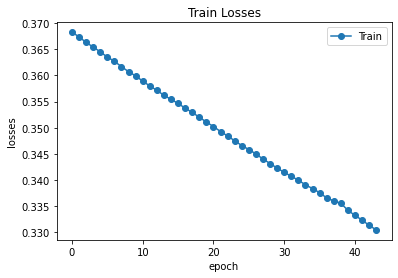

In [ ]:
plt.plot(save_loss_train,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train'])
plt.title('Train Losses')
 
plt.show()